# DeepLIFT Finalized Run
This notebook contains much of my finalized DeepLIFT interpretations of ADHunter. Much of it is the same as `250318_deeplift.ipynb`, but here I settled on using a baseline of all 0 values instead of averaging out one-hot-encoded inputs for non-activation domains. I found that this eliminated some of the odd results I got from using a baseline defined that way. 

#### Explanation of DeepLIFT properties
DeepLIFT explains the difference in the value of a neuron $t$ in terms of the differences of neurons $x_i$. It does this by computing multipliers for each $x_i$, which are defined as the contribution $C_{\Delta{x_i}\Delta{t}}$ divided by the $\Delta{x_i}$. The sums of all the contributions should add up to the difference between the model evaluated at the input and the baseline, which they call the **summation-to-delta** property: 

$$\Delta{t} = \sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}} = \sum_{i = 1}^{n}m_{\Delta{x_i}\Delta{t}}\Delta{x_i}$$

The current way I've been calculating importance (using `multiply_by_inputs=False`) is reporting the multipliers for each position, not the contributions. Thus, the summation-to-delta property does not hold if I sum up the scores reported this way. 

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("white")
# sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from captum.attr import LayerDeepLift
import logomaker
import os
os.chdir("../adhunter")

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in AD data

In [2]:
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

# load in AD data
fn = "../data/OrthologTilingDFwActivities_20240930_train_test_val.csv"
df = pd.read_csv(fn)
seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
thresh_neg = 50_000
df_ad = df.iloc[np.where(df["Activity"] >= thresh)[0]].copy()
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)
# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])
X_ad = torch.tensor(X[np.where(df["Activity"] >= thresh)[0]])
X_neg = torch.tensor(X[np.where(df["Activity"] < thresh_neg)[0]])

# Read in the Gcn4 array data and find the AA sequence of Gcn4 with 
# WLF mutated to A (non-activator) to use as baseline
gcn4_df = pd.read_csv("../data/Gcn4Array_Design.csv", index_col=0)
display(gcn4_df.loc[gcn4_df["Name"].str.contains("GCN4_CAAD40")])
# weak = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_7As_0", "ADseq"].unique().item() # WLF and MFYL > A
gcn4 = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_0", "ADseq"].unique().item()
weak = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_WLF_A_0", "ADseq"].unique().item() # WLF only > A

,ADseq,Name,ArrayDNA
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...


Load in model

In [ ]:
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))
model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ActCNNSystem(
  (model): ActCNN(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)

## DeepLIFT Baseline Choice

Appendix K of the [DeepLIFT paper](https://arxiv.org/abs/1704.02685) states: 
"*While it may seem natural to use a reference input of all zeros for one-hot encoded inputs, this neglects the fact that
one-hot encoded inputs have the constraint that one of the inputs will always be a 1. For genomics, we suggest using
a reference that is the average of one-hot encoded sequences from the negative set.*"

There's 2 ways of interpreting this. Either go and grab the most common AA at every position based on the one-hot-encoded values of the negative set (in our case, all non-activating 40mers), or average the one-hot-encoded representations across the negative set and use that directly as an input. In the latter case, the baseline would not actually be one-hot-encoded, but would preserve the property that the values for the encoded vectors at each position sum to one. 

However, I've been finding weird results when using the averaged negative one-hot values, namely in terms of assigned importance of acidic residues. I wonder if this is because of the abundance of D and E in the negative baseline?

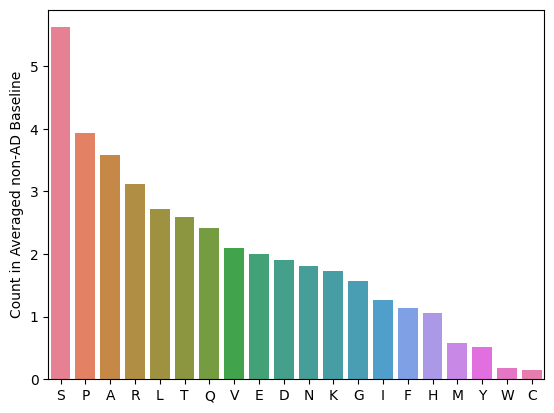

In [82]:
baseline_negad = model.model.encode(X_neg).mean(dim=0).unsqueeze(0)
dict(zip(list(alphabet), baseline_negad.sum(dim=1).numpy().flatten().round(0).astype(int)))
neg_comp = pd.DataFrame({0: dict(zip(list(alphabet), baseline_negad.sum(dim=1).numpy().flatten()))})
sns.barplot(neg_comp.sort_values(by=0, ascending=False).T)
plt.ylabel("Count in Averaged non-AD Baseline")
plt.show()

In [ ]:
baseline_neg = torch.zeros(1, 40, 20)

# baseline_neg_true_one_hot = model.model.encode(baseline_neg.squeeze().argmax(dim=-1)).unsqueeze(0)

# print(f"Model prediction of averaged one-hot-encoded negative set: {model(baseline_neg).item()}")
# print(f"Model prediction of true one-hot negative set: {model(baseline_neg_true_one_hot).item()}")
print(f"Model prediction of all 0 one-hot negative set: {model(baseline_neg).item()}")

Model prediction of all 0 one-hot negative set: -0.015430524945259094


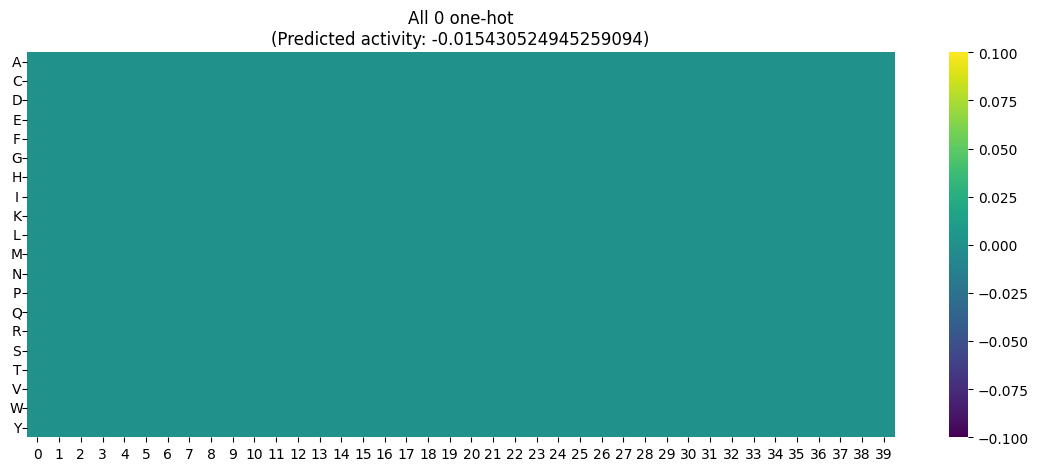

In [5]:
baseline_df = pd.DataFrame(baseline_neg.squeeze()).T
baseline_df.index = list(alphabet)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
ax.set_xticklabels(range(40), ha="center", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
ax.set_title(f"All 0 one-hot\n(Predicted activity: {model(baseline_neg).item()})")
plt.show()

# baseline_df = pd.DataFrame(baseline_neg_true_one_hot.squeeze()).T
# baseline_df.index = list(alphabet)
# fig, ax = plt.subplots(figsize=(14, 5))
# sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
# ax.set_xticklabels(range(40), ha="center", rotation=0)
# ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
# ax.set_title("Most common residue across negative set at each position")
# plt.show()

## DeepLIFT on ADs vs. Null Baseline

In [6]:
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
attr = dl.attribute(model.model.encode(X_ad), baseline_neg, attribute_to_layer_input=True)


In [7]:
def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True).detach().numpy()
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None, cmap="seismic"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap=cmap, center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)

The summation-to-delta property holds for the contribution scores obtained here (although it seems like there's a bit of floating point error)

$$\Delta{t} = \sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}}$$

In [8]:
attr_sums = attr.sum(dim=1).sum(dim=1).detach().numpy()
dts = (model(X_ad) - model(baseline_neg)).detach().numpy().flatten()

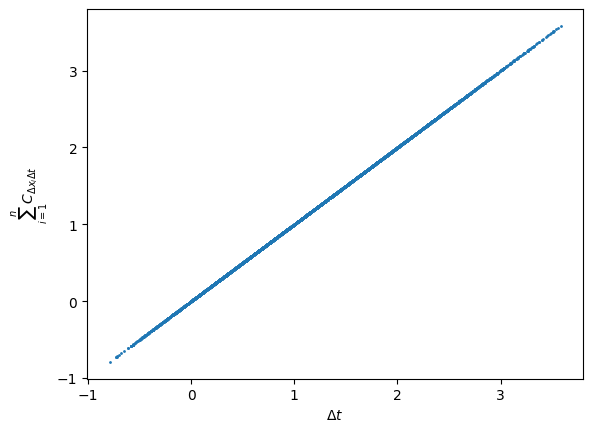

In [9]:
# plt.plot(np.arange(max(dts)), np.arange(max(dts)), c='k', alpha=.5)
plt.scatter(x=dts, y=attr_sums, s=1)
plt.xlabel(r"$\Delta{t}$")
plt.ylabel(r"$\sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}}$")
plt.show()

# Results plot

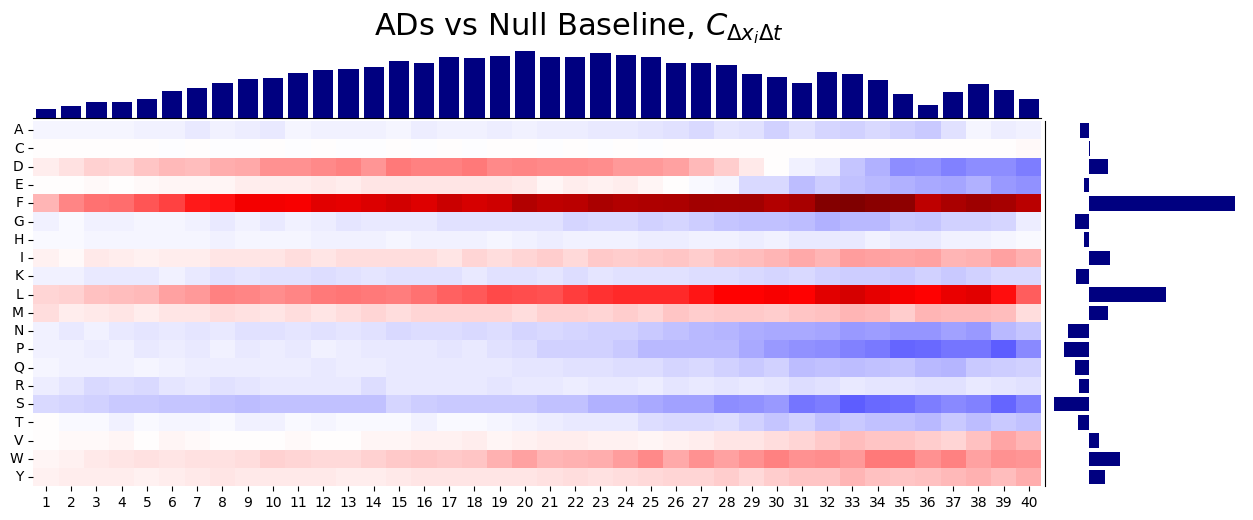

In [84]:
def joint_plot(attr_df, title=""):
    attr_df_melt = (attr_df
                        .rename_axis("AA")
                        .reset_index()
                        .melt(
                            id_vars=['AA'], 
                            var_name='pos', 
                            value_name='val'))

    D = 40
    H = 20
    df_ = attr_df_melt

    g = sns.jointplot(data=df_, x='AA', y='pos', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(
        data=df_['val'].to_numpy().reshape(D, H).T, 
        ax=g.ax_joint, cbar=False, cmap='seismic', 
        center=0)

    g.ax_marg_y.barh(np.arange(0.5, H), df_.groupby(['AA'])['val'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df_.groupby(['pos'])['val'].sum().to_numpy(), color='navy')

    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    g.ax_joint.set_yticks(np.arange(0.5, H))
    g.ax_joint.set_yticklabels(list(alphabet), rotation=0)

    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

    g.fig.set_size_inches(14,5)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    plt.suptitle(title, fontsize=22, y=1.05)
    plt.show()

joint_plot(attr_df, r"ADs vs Null Baseline, $C_{\Delta{x_i}\Delta{t}}$")

## Further exploring DeepLIFT properties

##### **Note** that much of this was intended for understanding the averaged negative baseline rather than the null baseline used here. Using a null baseline results in $m_i |\Delta{x_i}| = c_i$ for all $i$, so the correction has no effect here. 

If we attribute for a single sequence, generally it looks like importance scores are only high or low in positions corresponding to that sequence's AA at each position, for instance, the gcn4 sequence here:

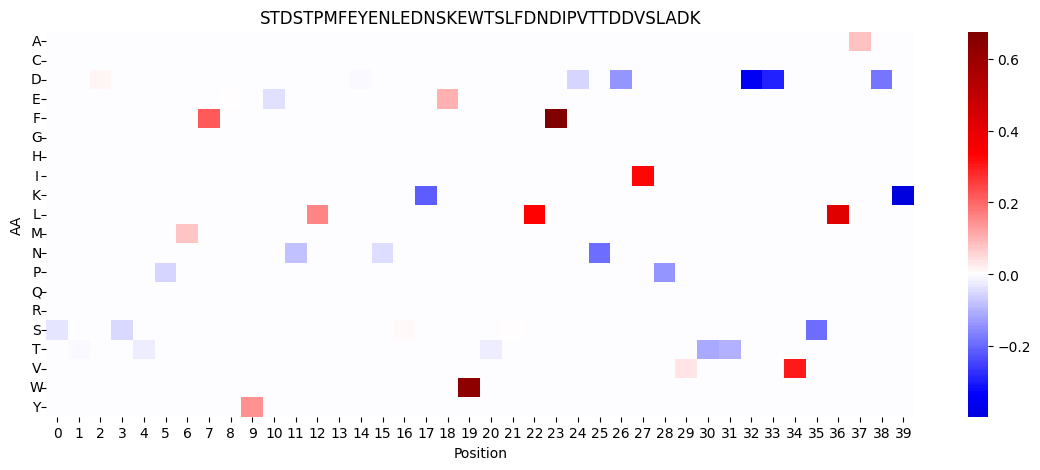

In [11]:
gcn4_attr_null = get_attr(dl, model.model.encode(gcn4), baseline_neg)
plot_attr(gcn4_attr_null, title=gcn4)
plt.show()
# np.where([i == "D" for i in gcn4])

But how is multiply_by_inputs actually working? To test this, let's compare that Gcn4 sequence with the same sequence but with the WLF motif mutated to A's, which we know shouldn't activate:

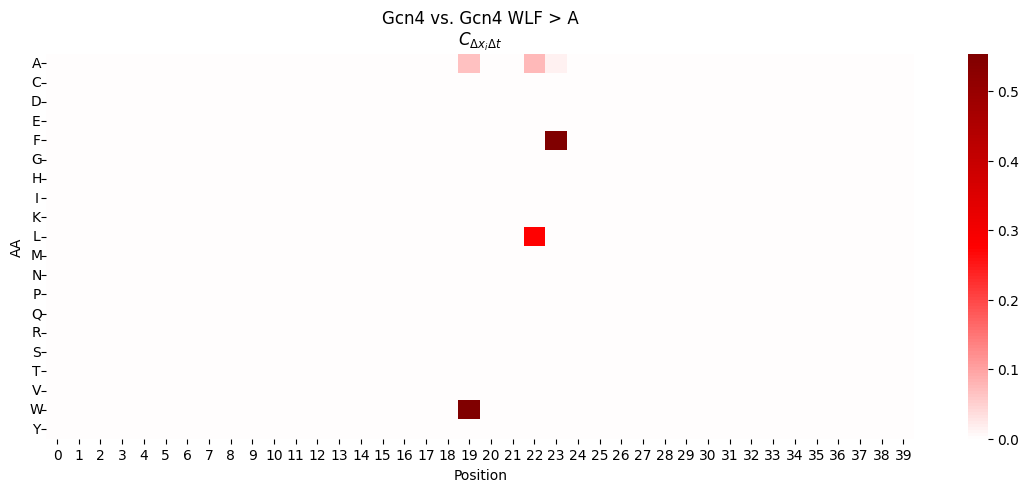

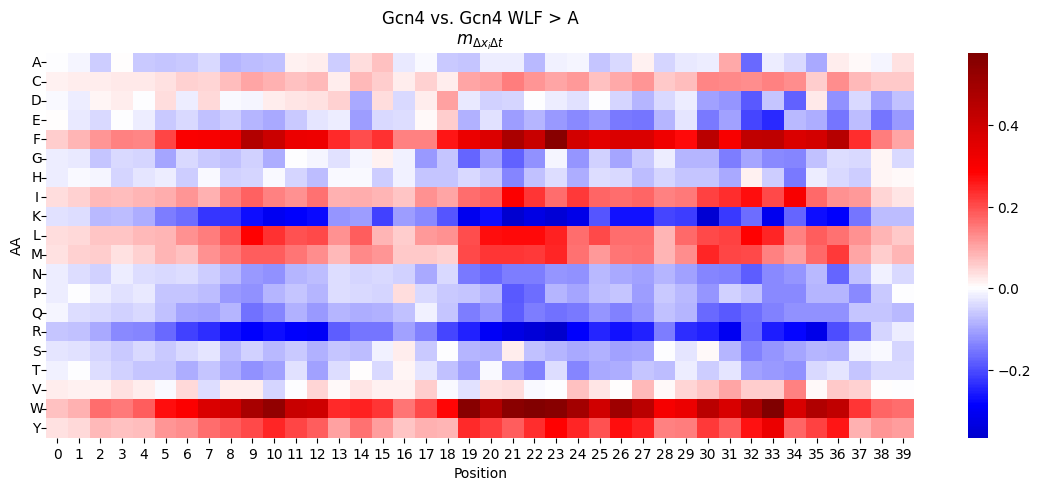

In [12]:
dl_m = LayerDeepLift(model, model.model.emb, multiply_by_inputs=False)
gcn4_enc, weak_enc = model.model.encode(gcn4), model.model.encode(weak)

# comp_title = f"{gcn4}\nvs.\n{weak}\n"
comp_title = "Gcn4 vs. Gcn4 WLF > A\n"
attr_gcn4 = get_attr(dl, gcn4_enc, weak_enc)
plot_attr(attr_gcn4, title=comp_title + r"$C_{\Delta{x_i}\Delta{t}}$")
plt.show()

multipliers = dl_m.attribute(gcn4_enc, weak_enc, attribute_to_layer_input=True).squeeze().detach().numpy()
mdf = pd.DataFrame(multipliers).T
mdf.index = list(alphabet)
plot_attr(mdf, title=comp_title + r"$m_{\Delta{x_i}\Delta{t}}$")
plt.show()

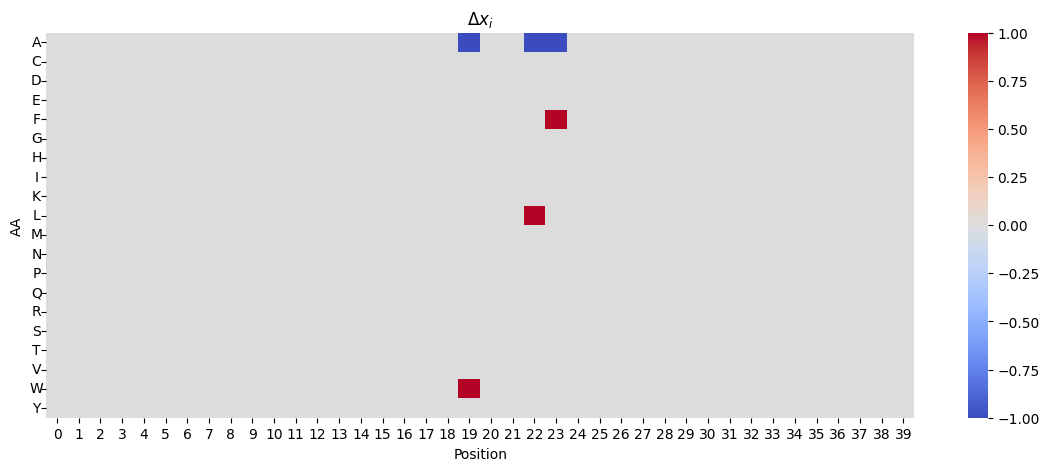

In [13]:
delta_x = (gcn4_enc - weak_enc).squeeze().detach().numpy()
dx_df = pd.DataFrame(delta_x).T
dx_df.index = list(alphabet)
plot_attr(dx_df, title=r"$\Delta{x_i}$", cmap='coolwarm')
plt.show()

Sure enough multiplying $\Delta{x_i}$ by $m_{\Delta{x_i}\Delta{t}}$ at each $x_i$ gives us the original contributions matrix:

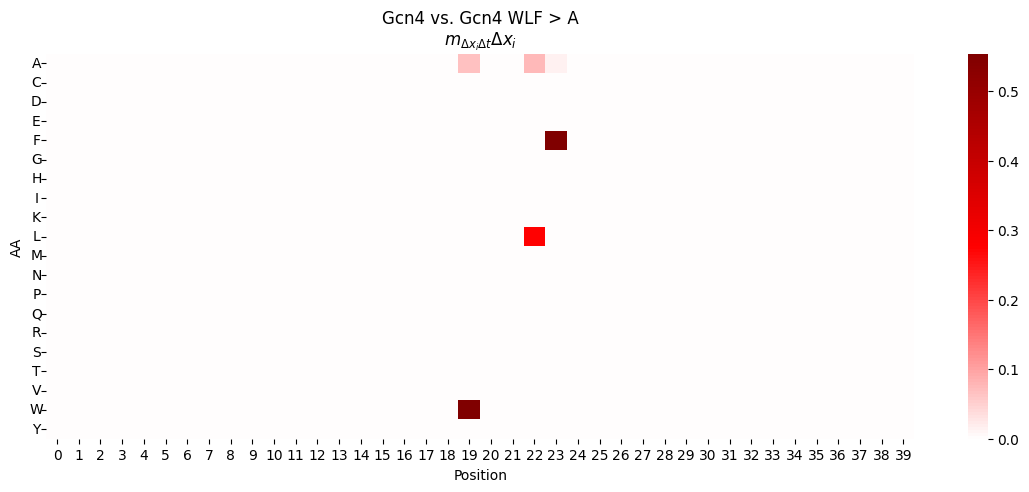

All values match!


In [14]:
c = multipliers * delta_x
cdf = pd.DataFrame(c).T
cdf.index = list(alphabet)
plot_attr(cdf, title=comp_title + "$m_{\Delta{x_i}\Delta{t}}\Delta{x_i}$")
plt.show()

if (cdf == attr_gcn4).values.flatten().all():
    print(r"All values match!")

Notably, the Alanines substituted for the motif have $C_{\Delta{x_i}\Delta{t}} > 0$, and we can see that this is because $\Delta{x_i}, m_{\Delta{x_i}\Delta{t}} < 0$ at these positions. I'd interpret this as meaning that ***Alanines negatively affect activation at these positions, so because gcn4 doesn't have alanines there, its activation is higher.***

In other words, losing these alanines in contrast to the reference sequence increases activation. If both the input and reference are one-hot encoded, multiplying the $m_{\Delta{x_i}\Delta{t}}$ by $|\Delta{x_i}|$ helps us get a better idea of what direction the effects are when a given aa is added somewhere:

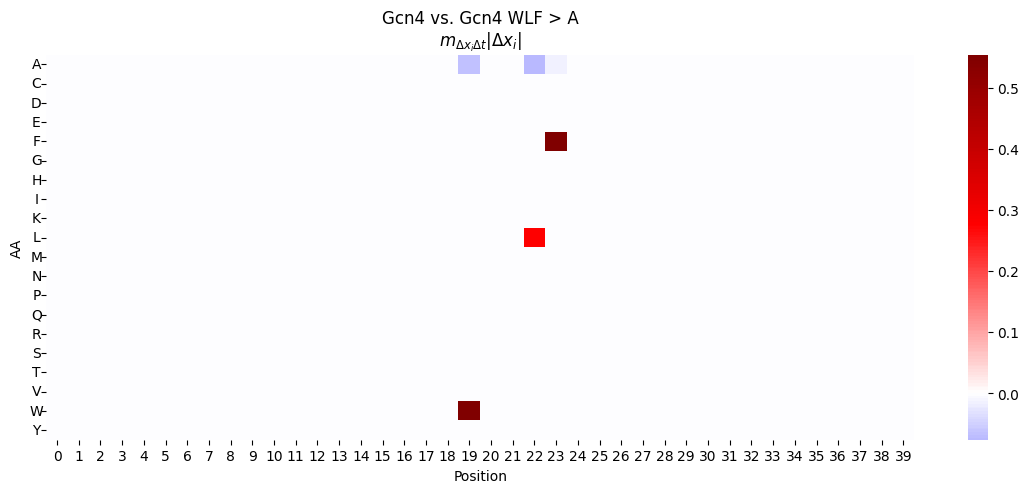

In [15]:
c = multipliers * np.abs(delta_x)
cdf = pd.DataFrame(c).T
cdf.index = list(alphabet)
plot_attr(cdf, title=comp_title + "$m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()

But what if we follow the same procedure comparing to the null baseline? In this case, the values of the baseline matrix are floats at each position instead of 1 or 0

<Axes: title={'center': 'Gcn4 vs average non-activating baseline\n$\\Delta{x_i}$'}, xlabel='Position', ylabel='AA'>

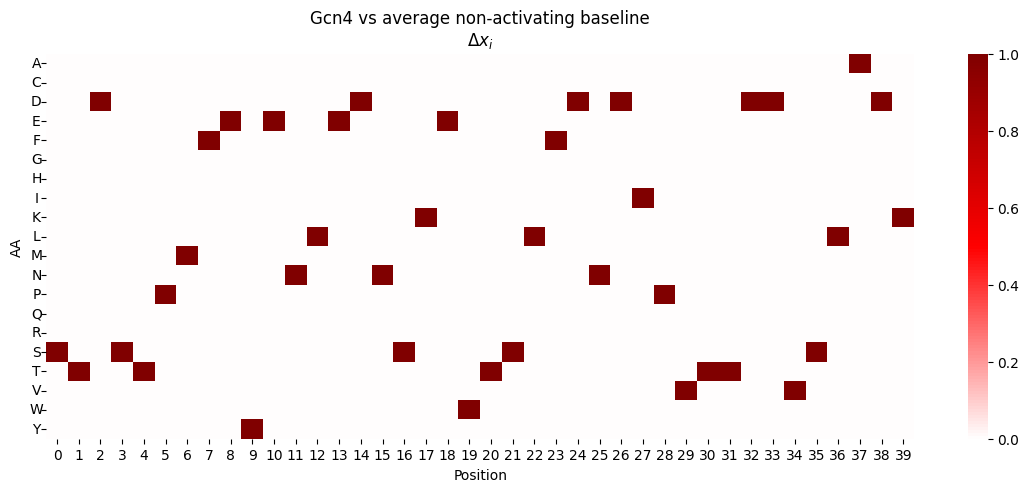

In [16]:
delta_x_null = (gcn4_enc - baseline_neg).squeeze().detach().numpy()
dxn_df = pd.DataFrame(delta_x_null).T
dxn_df.index = list(alphabet)
ctitle = "Gcn4 vs average non-activating baseline\n"
plot_attr(dxn_df, title=ctitle + "$\Delta{x_i}$")

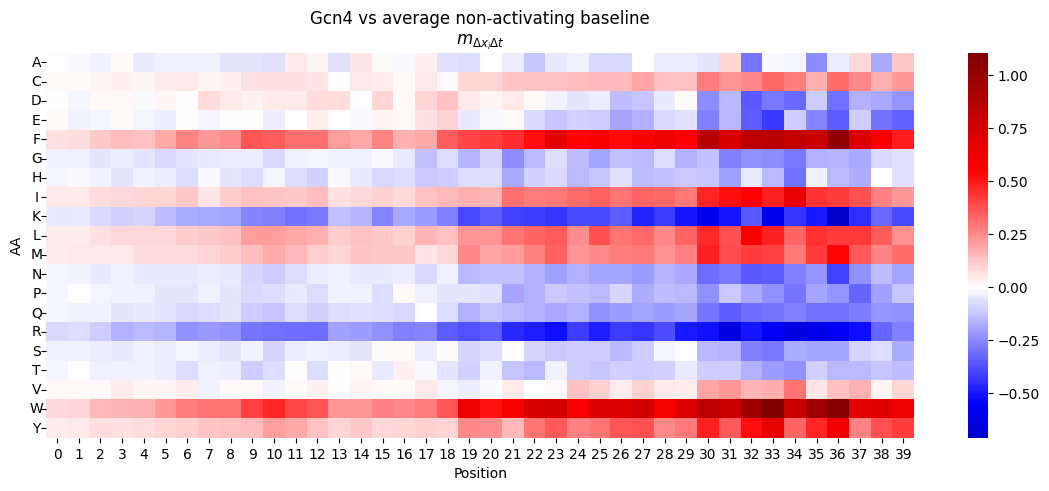

Multipliers * ∆x match contributions


In [17]:
gcn4_mult_null = get_attr(dl_m, gcn4_enc, baseline_neg)
plot_attr(gcn4_mult_null, title=ctitle + "$m_{\Delta{x_i}\Delta{t}}$")
plt.show()

if (gcn4_mult_null.T.values * delta_x_null == gcn4_attr_null.T.values).all():
    print("Multipliers * ∆x match contributions")

This gives a better idea of what direction the effect of having a given residue would be at each position:

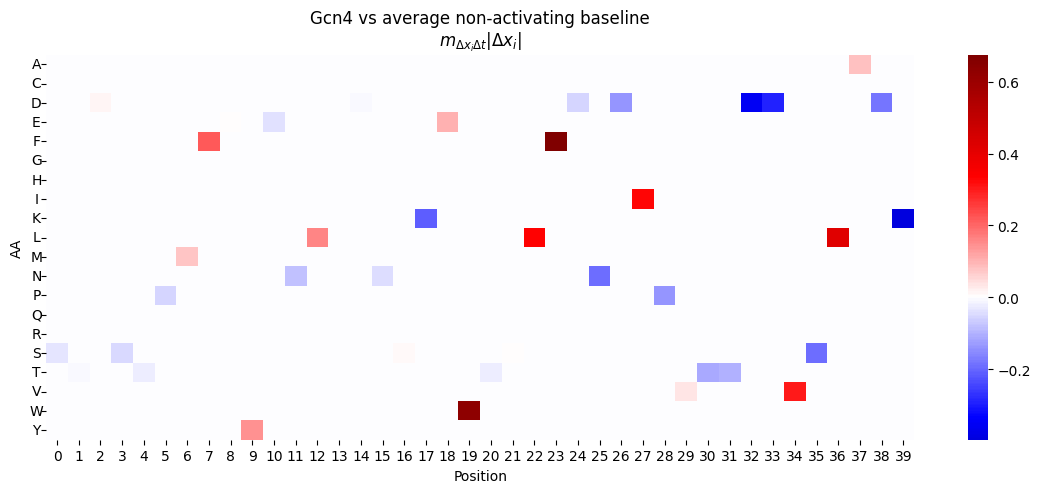

In [18]:
plot_attr(gcn4_mult_null * np.abs(dxn_df), 
          title=ctitle + "$m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()

Let's apply this across all ADs to see directionality of important features:

In [19]:
X_ad_enc = model.model.encode(X_ad)
ad_multipliers = dl_m.attribute(X_ad_enc, baseline_neg, attribute_to_layer_input=True)
# ads_mult_null = get_attr(dl_m, X_ad_enc, baseline_neg)
# X_ad.shape

Let's plot the average value of the multipliers ($\bar{m}_{\Delta{x_i}\Delta{t}}$) across ADs:

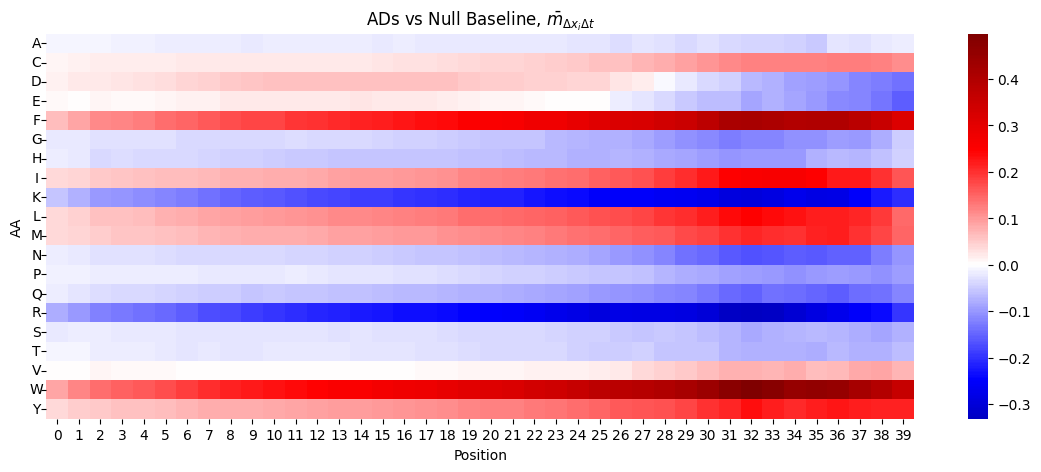

In [56]:
ad_mult_df = pd.DataFrame(ad_multipliers.mean(axis=0)).T
ad_mult_df.index = list(alphabet)
plot_attr(ad_mult_df, title="ADs vs Null Baseline, $\\bar{m}_{\Delta{x_i}\Delta{t}}$")
plt.show()

And now multiply each $m_{\Delta{x_i}\Delta{t}}$ by each $|\Delta{x_i}|$, then average across all ADs:

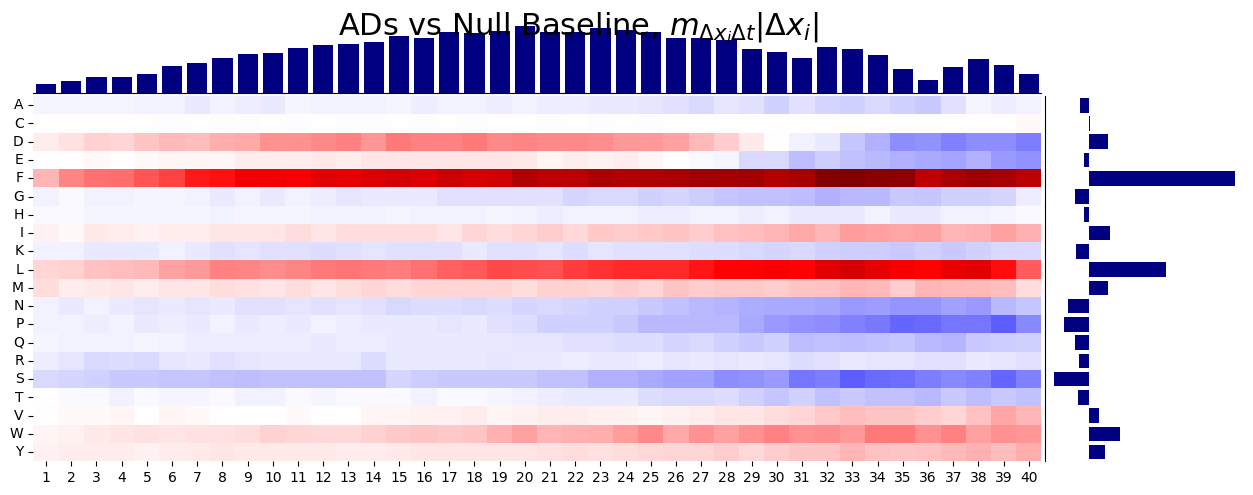

In [57]:
ad_dx = X_ad_enc - baseline_neg
ad_m_abs_dx = ad_multipliers * torch.abs(ad_dx)
mean_attr = ad_m_abs_dx.squeeze().detach().numpy().mean(axis=0)

ad_attr_absdx = pd.DataFrame(mean_attr).T
ad_attr_absdx.index = list(alphabet)
# plot_attr(ad_attr_absdx, title="ADs vs averaged non-ADs, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
# plt.show()
joint_plot(ad_attr_absdx, title="ADs vs Null Baseline, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()
# (()[0] == (ad_multipliers[0] * ad_dx[0])).all()